In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
from keras.layers import Dense 
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import plot_model 
from keras import models
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
import csv 
import pandas as pd
import numpy as np
from numpy.random import seed

In [ ]:
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from datetime import timedelta
import time
import tensorflow as tf
import keras as keras
from keras.models import Sequential
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
#Download the data which are a drive
from google.colab import drive
drive.mount('/content/drive')
serie_inflation = pd.read_csv('/content/drive/My Drive/Copie de CPIAUCSL.csv')
#we create a data frame with only the datas we will use for the model 
serie_inflation["DATE"]=pd.to_datetime(serie_inflation["DATE"])
serie_inflation.set_index('DATE',inplace=True)
serie_inflation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,CPIAUCSL
DATE,
1947-01-01,21.480
1947-02-01,21.620
1947-03-01,22.000
1947-04-01,22.000
1947-05-01,21.950
...,...
2021-10-01,276.590
2021-11-01,278.524
2021-12-01,280.126


In [ ]:
#Splitting data into test and train
splitting_date = 876 
train_data , validation_data = serie_inflation[:splitting_date] , serie_inflation[splitting_date:]

In [ ]:
#Computing mean and standard deviation of train data
mean_train = train_data.mean()
std_train = train_data.std()

#Normalizing the data
train_data = (train_data - mean_train)/std_train
validation_data = (validation_data - mean_train)/std_train
serie_inflation = (serie_inflation - mean_train)/std_train

train_data

,CPIAUCSL
DATE,
1947-01-01,-1.140266
1947-02-01,-1.138465
1947-03-01,-1.133576
1947-04-01,-1.133576
1947-05-01,-1.134219
...,...
2019-08-01,1.879403
2019-09-01,1.884768
2019-10-01,1.893890


In [ ]:
#define X_train and y_train using lagged data, we are using the inflation on the past 6 years in order to try to forecast the following data
# Hence they will be 72 lagged time-steps and 1 output

X_train  = []
y_train = []
lagg = 72 
for i in range(lagg,splitting_date):
  X_train.append(train_data[i-lagg:i])
  y_train.append(train_data[i:i+1])
X_train , y_train = np.array(X_train) , np.array(y_train)
print(X_train.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape

(804, 72, 1)


(804, 72, 1)

In [ ]:
network = models.Sequential()

#Adding the first LSTM layer 
network.add(LSTM(units = 100, activation = 'relu' ,  return_sequences = False, input_shape = (X_train.shape[1], 1)))
#Adding Classic layers
network.add(layers.Dense(50 , activation = 'relu'))
network.add(layers.Dense(50 , activation = 'relu'))
network.add(layers.Dense(15 , activation = 'relu'))

network.add(Dense(units = 1))

network.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error')

network.fit(X_train, y_train, epochs = 50)

Epoch 1/50
26/26 [==============================] - 3s 48ms/step - loss: 24073676093652992.0000
Epoch 2/50
26/26 [==============================] - 1s 46ms/step - loss: 0.1255
Epoch 3/50
26/26 [==============================] - 1s 45ms/step - loss: 0.0027
Epoch 4/50
26/26 [==============================] - 1s 45ms/step - loss: 4.0381e-04
Epoch 5/50
26/26 [==============================] - 1s 45ms/step - loss: 1.9054e-04
Epoch 6/50
26/26 [==============================] - 1s 45ms/step - loss: 1.4874e-04
Epoch 7/50
26/26 [==============================] - 1s 44ms/step - loss: 1.2770e-04
Epoch 8/50
26/26 [==============================] - 1s 47ms/step - loss: 1.0800e-04
Epoch 9/50
26/26 [==============================] - 1s 45ms/step - loss: 9.3087e-05
Epoch 10/50
26/26 [==============================] - 1s 46ms/step - loss: 8.0253e-05
Epoch 11/50
26/26 [==============================] - 1s 47ms/step - loss: 7.9500e-05
Epoch 12/50
26/26 [==============================] - 1s 45ms/step - lo

##Short Term Forecasting

In [ ]:
#Get the predicted values 

inputs = serie_inflation[len(serie_inflation) - len(validation_data) - lagg:]
X_test = []
for i in range(lagg , len(inputs)):
  X_test.append(inputs[i-lagg:i])
X_test = np.array(X_test)  

predicted_inflation = network.predict(X_test)

In [ ]:
predicted_inflation

array([[1.922185 ],
       [1.9283062],
       [1.933857 ],
       [1.9338131],
       [1.9250981],
       [1.9198716],
       [1.9223354],
       [1.9293569],
       [1.9380466],
       [1.9460711],
       [1.9518895],
       [1.9574571],
       [1.9649372],
       [1.9725318],
       [1.9826434],
       [1.9966145],
       [2.0129952],
       [2.0318043],
       [2.0544002],
       [2.0741472],
       [2.0912848],
       [2.1079614],
       [2.1300328],
       [2.1529684],
       [2.175292 ],
       [2.19823  ]], dtype=float32)

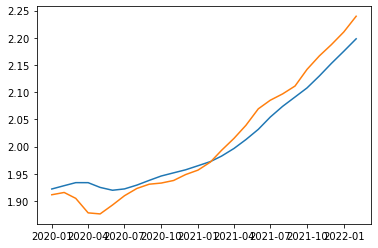

In [ ]:
plt.plot(validation_data.index , predicted_inflation)
plt.plot(validation_data)

In [ ]:
#Return to unnormalize prediction with the normalize one
forecasting_inflation = pd.DataFrame(index = validation_data.index , data = {
    "Normalize Forecasting": predicted_inflation.tolist(),
    "Forecasting": (predicted_inflation * std_train.values[0] + mean_train.values[0]).tolist()
})

for i in range(len(forecasting_inflation)):
  forecasting_inflation["Forecasting"][i] = np.array(forecasting_inflation["Forecasting"][i])[0]
  forecasting_inflation["Normalize Forecasting"][i] = np.array(forecasting_inflation["Normalize Forecasting"][i])[0]

forecasting_inflation

,Normalize Forecasting,Forecasting
DATE,,
2020-01-01,1.922185,259.50415
2020-02-01,1.928306,259.979919
2020-03-01,1.933857,260.411346
2020-04-01,1.933813,260.407959
2020-05-01,1.925098,259.730591
2020-06-01,1.919872,259.324341
2020-07-01,1.922335,259.515869
2020-08-01,1.929357,260.061584
2020-09-01,1.938047,260.737


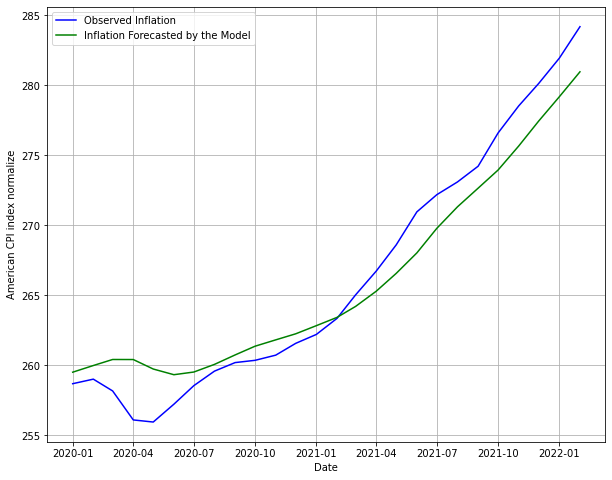

In [ ]:
#Plot the forecast
plt.figure(figsize=(10,8))
plt.plot(validation_data *std_train.values[0] + mean_train.values[0]  , color = "blue" , label= "Observed Inflation")
plt.plot(forecasting_inflation["Forecasting"] , color = "green" , label = "Inflation Forecasted by the Model")
plt.ylabel("American CPI index normalize")
plt.xlabel("Date")
plt.legend()
plt.grid()

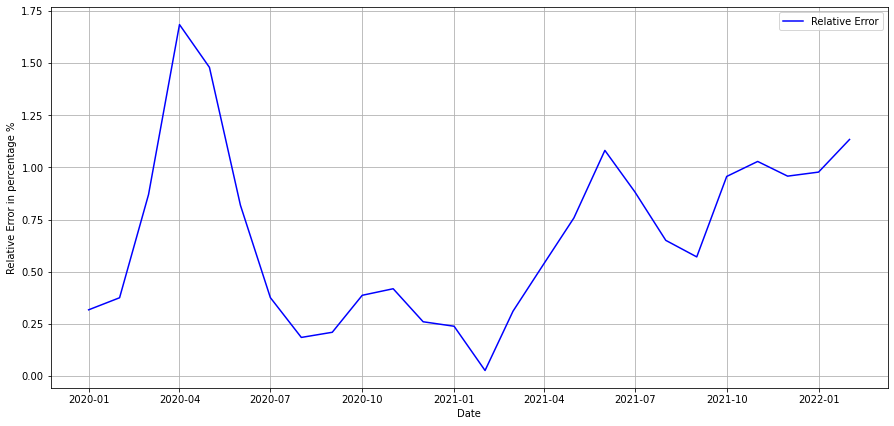

In [ ]:
#Relative Error
Relative_Error = np.abs(forecasting_inflation["Forecasting"].values - (validation_data["CPIAUCSL"].values * std_train.values[0] + mean_train.values[0])) / (validation_data["CPIAUCSL"].values * std_train.values[0] + mean_train.values[0])
plt.figure(figsize=(15,7))
plt.plot(validation_data.index , Relative_Error * 100 , color = "blue" , label = "Relative Error")
plt.ylabel("Relative Error in percentage %")
plt.xlabel("Date")
plt.legend()
plt.grid()

##Long Term Forecasting

In [ ]:
## Forecast values using the forecast values
## Creation the input for the each simulation


inputs = serie_inflation[len(serie_inflation) - len(validation_data) - lagg:]
dynamics_prediction = []
for i in range(len(validation_data)):
  X_test = []
  X_test.append(inputs[i:i+lagg])
  X_test = np.array(X_test)
  prediction = network.predict(X_test) #computing prediction

  inputs[i+lagg:i+1+lagg]["CPIAUCSL"].values[0] = prediction[0][0] #Change the known value of inflation by the predicted one
  dynamics_prediction.append(prediction[0][0])
  
display(dynamics_prediction)

1.9049549949927294

1.9415870904922485

[1.922185,
 1.9320147,
 1.9415871,
 1.9511564,
 1.9607596,
 1.9704285,
 1.9801891,
 1.9900637,
 2.0000706,
 2.0102232,
 2.0205326,
 2.0310078,
 2.0416563,
 2.0524843,
 2.0634985,
 2.0747116,
 2.0861177,
 2.097714,
 2.109498,
 2.1214767,
 2.1336534,
 2.146032,
 2.1586595,
 2.171528,
 2.1846159,
 2.197905]

In [ ]:
#constructing the unnormalize index
dynamics_forecasting_inflation = pd.DataFrame(index = validation_data.index , data = {
    "Normalize Forecasting": dynamics_prediction,
    "Forecasting": (np.array(dynamics_prediction) * std_train.values[0] + mean_train.values[0]).tolist()
})
dynamics_forecasting_inflation

,Normalize Forecasting,Forecasting
DATE,,
2020-01-01,1.922185,259.504150
2020-02-01,1.932015,260.268188
2020-03-01,1.941587,261.012146
2020-04-01,1.951156,261.755920
2020-05-01,1.960760,262.502319
2020-06-01,1.970428,263.253815
2020-07-01,1.980189,264.012451
2020-08-01,1.990064,264.779907
2020-09-01,2.000071,265.557678


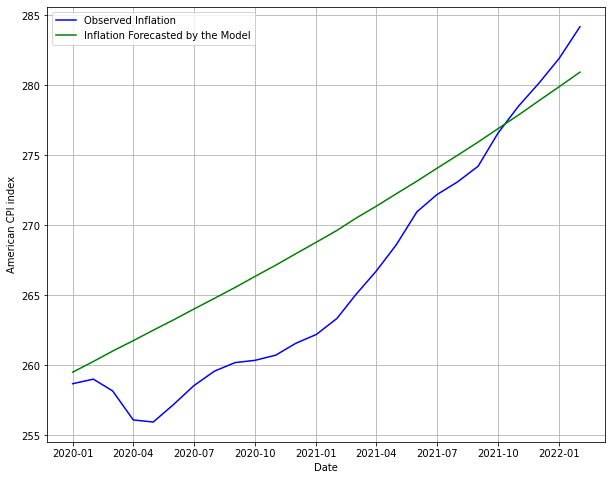

In [ ]:
#Plot the forecast
plt.figure(figsize=(10,8))
plt.plot(validation_data *std_train.values[0] + mean_train.values[0]  , color = "blue" , label= "Observed Inflation")
plt.plot(dynamics_forecasting_inflation["Forecasting"] , color = "green" , label = "Inflation Forecasted by the Model")
plt.ylabel("American CPI index")
plt.xlabel("Date")
plt.legend()
plt.grid()

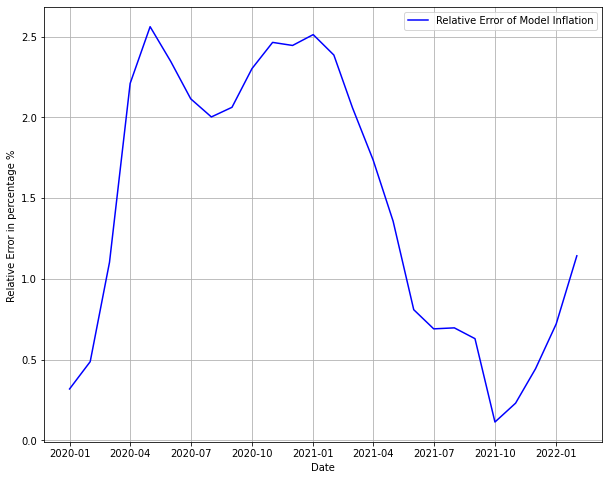

In [ ]:
#Plot Relative Error
Relative_Error_dyn = np.abs(dynamics_forecasting_inflation["Forecasting"].values - (validation_data["CPIAUCSL"].values * std_train.values[0] + mean_train.values[0])) / (validation_data["CPIAUCSL"].values * std_train.values[0] + mean_train.values[0])
plt.figure(figsize=(10,8))
#plt.plot(validation_data.index , Relative_Error * 100 , color = "green" , label = "Relative Error of Model 1")
plt.plot(validation_data.index , Relative_Error_dyn * 100 , color = "blue" , label = "Relative Error of Model Inflation")
plt.ylabel("Relative Error in percentage % ")
plt.xlabel("Date")
plt.legend()
plt.grid()